In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

# This code solves the energy balance model used in Roe et al. (Nat. Geosci., 2015)
# The model operates in climatology mode
# You can specify:-
# the insolation Q0
# the OLR parameters, A0,B0
# the diffusivity, D
# albedo of ocean and ice
# whether you diffuse moist static energy, or just sensible heat

In [2]:
#time step in fraction of year
delt=1./500000;
NMAX=10000000;

#set up x array (x = sine of latitude).
jmx=101; #101
delx = 2.0/jmx;
x = np.arange(-1.0+delx/2,1.0,delx)
phi = np.arcsin(x)*180/np.pi;

# I think this C = rho * c * h_ml /(pi*1e7).
# this is consistent with a ~1m layer of dirt
# Note - heat capacity over LAND for fast convergence
Cl = 0.2; # units: J /(m2 K)

In [3]:
# climate parameters
Q0 = 342;                          # [W m-2]  solar constant n.b. 4Q0 = 1368
A0 = 207.3;                        # Size of longwave cooling constant [W/m2]
B0 = 2.09;                         # [W m-2 degC-1] OLR response NOTE UNITS
alf_noice = 0.3;                   # [] ice free albedo.
alf_ice = 0.55;                    # [] ice covered albedo.

A = A0;
B = B0*np.ones(x.size); # longwave cooling [W/(m2 K)]

In [4]:
# Moisture parameters
relhum = 0.8;   # relative humidity
eps = 0.622;    # moisture coonstant
psfc = 9.8e4;   # (Pa)
e0 = 611.2;     # vap. press (Pa)
a = 17.67; b = 243.5;   # sat vap constants !!T must be in temperature
L = 2.45e6;         # latent heat of vaporization (J kg-1)
cp = 1004;          # (J kg-1 K-1)

In [5]:
# magnitude of diffusivity
Dmag = 0.2598; # D = 0.2598 W/(m2 K) is the value used by TF10 
D=Dmag*np.ones(jmx+1); # diffusivity for MSE

In [6]:
# For dry energy balance model, uncomment these lines:
# Dmag = 0.44; # magnitude of diffusivity [W/(m2 K)]
# D=Dmag*np.ones(jmx+1); # diffusivity for sensible (cp*T)
# relhum = 0;  # switch off humidity

In [7]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array.
lam=(1-np.square(np.arange(-1.0,1.0+delx,delx)))/np.square(delx);
lam=np.multiply(D, lam); 

M = np.zeros((jmx,jmx));

M[0,0] =  - lam[1];
M[0,1] = lam[1];

M[jmx-1,jmx-2] = lam[jmx-1];
M[jmx-1,jmx-1]   = - lam[jmx-1];

for j in range(1, jmx-1): 
  M[j,j-1] = lam[j]
  
  M[j,j]   = - (lam[j+1]+lam[j])
  
  M[j,j+1] = lam[j+1]


Mdiv = M; #Divergence matrix    
    

In [8]:
#set up inital T profile 
T = 0.5*(1-1*np.square(x));
Tinit=T;
Tglob = np.mean(Tinit);
#T.shape

In [9]:
# Timestepping loop
for j in range(0, NMAX-1): # use NMAX-1 #for n=1:NMAX
   
   #print(np.mean(T)) 
  
   # Calculate Source  (ASR) for this loop:
   alf = alf_noice*np.ones(x.size)
   for idx, item in enumerate(T):
    if item <= -10:
        alf[idx] = alf_ice 
    
   Src = Q0*(1-0.241*(3*np.square(x)-1))*(1-alf);
   
    # spec. hum, and theta_e
   q = eps*relhum/psfc*e0*np.exp(a*(T)/(b+(T)));  #q=q(:); # here T is in oC. q is g kg-1
   
   theta_e = 1/cp*(cp*((T)+273.15) + L*q); # note units of Kelvin are needed!!!
   
    
    # Calculate new T from Source and Sink terms.
    # Diffuse moist static energy (theta_e)
   dT = delt/Cl*(Src -A - (B*T) + np.matmul(Mdiv,theta_e));
   
   T = T + dT; 
    
   #print(np.mean(T))

  # Check to see if global mean energy budget has converged:   
   Fglob=np.mean(Src - A - (B*T))
    
   if np.absolute(Fglob) < 0.001: #if (abs(Fglob) < 0.001), break; end
        break  
print(Fglob) 

0.0009999886750876213


In [19]:
print(np.mean(T))
divF = -np.matmul(Mdiv,theta_e);
h = theta_e*cp;

14.476018412990436


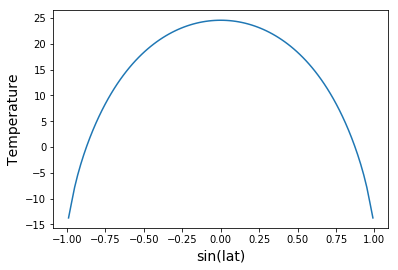

In [39]:
#matLabData = io.loadmat('ERAtemperature.mat') #loads matlab file as a dictionary with some metadata
#matLabData.keys() #tell me what's in the dictionary
#lat = np.asarray(matLabData['lat'])
#t = np.asarray(matLabData['T'])
plt.plot(x,T)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.show()


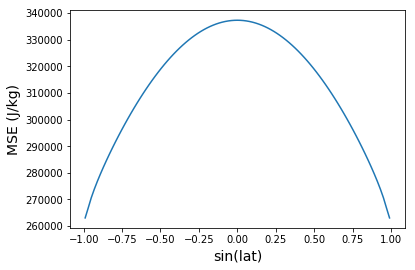

In [38]:
plt.plot(x,h)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('MSE (J/kg)', fontsize=14)
plt.show()

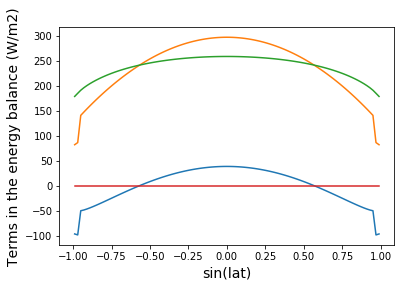

In [35]:
Snk = A+B*T
plt.plot(x,divF)
plt.plot(x,Src)
plt.plot(x,Snk)
plt.plot(x,Src-divF-Snk)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Terms in the energy balance (W/m2)', fontsize=14)
plt.show()